# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
df = pd.DataFrame(data.copy(deep=True))

In [4]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

#### В датафрейме имеются столбцы различных типов данных, имеются строковые, например first_day_exposition - его мы переведем в формат даты на этапе предобработки. Много столбцов типа float, некоторые из них для удобства можно будет перевести в int. Имеются пропуски, рассмотрим их количество ниже

In [6]:
#количество пропусков
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
df.is_apartment.value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

#### Для многих квартир не указано - апартаменты это или нет. Наверное просто забыли, для заполнения пропусков надо будет использовать False. Возможно также перевести столбец в булевый, тогда надо будет заполнять нулями. Рассмотрим подробнее пропущенные значения на шаге 2.

### Вывод

>Датасет содержит 22 столбца и 23699 строк, во многих строках имеются множественные пропуски, которые придется заполнять разными методами. Некоторые будем заполнять нулями или False, количественные - медианами, а некоторые данные, возможно, получится достать из уже имеющихся.
Датасет также содержит различные типы данных, которые мы также преобразуем на втором шаге - предобработка данных. 

### Шаг 2. Предобработка данных

#### Рассмотрим высоту потолков

In [8]:
df[df.ceiling_height.isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,NaN,...,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200000.0,39.0,2017-12-16T00:00:00,1,NaN,9.0,20.0,6,NaN,...,11.0,2.0,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0
23690,3,5500000.0,52.0,2018-07-19T00:00:00,2,NaN,5.0,31.0,2,NaN,...,6.0,NaN,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23692,2,1350000.0,30.0,2017-07-07T00:00:00,1,NaN,5.0,17.5,4,NaN,...,6.0,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.0,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.5,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0


Обнаружили выброс при значении этажей = 36, посмотрим с чем это связано

In [9]:
df[df.floors_total == 36]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
397,15,5990000.0,54.0,2018-03-22T00:00:00,2,NaN,36.0,21.4,28,NaN,...,18.7,1.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
11079,16,9200000.0,75.0,2019-02-22T00:00:00,2,2.7,36.0,40.0,29,NaN,...,12.0,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN


###### Заметим, что расстояния до аэропорта и до центра одинаковое для всех трех квартир, следовательно это один и тот же дом. Наверняка у всех квартир одинаковая высота потолков. Заменим 27 на 2.7

In [10]:
df.loc[5807, 'ceiling_height'] = 2.7
df.loc[397, 'ceiling_height'] = 2.7

Проверим какие еще есть выбросы в бОльшую сторону по высоте потолков в нашей выборке

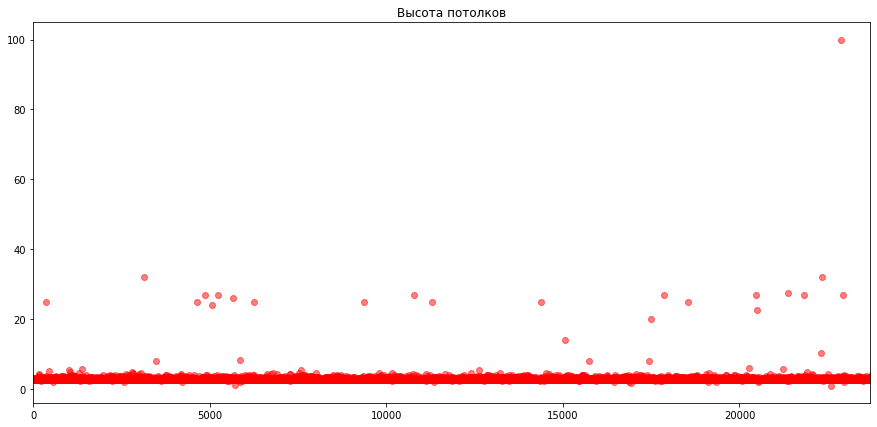

In [11]:
df.ceiling_height.plot(style="ro", figsize=(15,7), alpha=0.5, title='Высота потолков')
plt.show()

Аномальных значений не так много, в основной массе высота потолков приблизительно равняется 2-3 метрам. Изучим выбросы подробнее, т.е. наблюдения, где высота потолков больше 20м.

In [12]:
df[df.ceiling_height > 20]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,...,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000.0,50.0,2017-08-08T00:00:00,2,26.0,9.0,21.3,3,NaN,...,7.0,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
6246,6,3300000.0,44.4,2019-03-25T00:00:00,2,25.0,5.0,31.3,5,NaN,...,5.7,NaN,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9379,5,3950000.0,42.0,2017-03-26T00:00:00,3,25.0,5.0,30.0,2,NaN,...,5.2,NaN,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN
10773,8,3800000.0,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,...,8.1,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0


Складывается впечатление, что эти значения являются ошибкой при наборе с клавиатуры и истинное значение меньше на порядок. Единственный выброс - 100метровый потолок, не известно, что это, поэтому имеет смысл избавиться от этого наблюдения. Хотя выбросов и не так много, можно было бы и просто исключить их из наших данных, но я предпочту их оставить и поделить значения столбца высоты потолков на 10.

In [13]:
df = df.drop([22869]) #удаляем 100метровые потолки

In [14]:
df['ceiling_height'] = df['ceiling_height'].apply( lambda x: x if (x < 20) else x/10 ) # делим значения потолков, которые больше 20 на 10

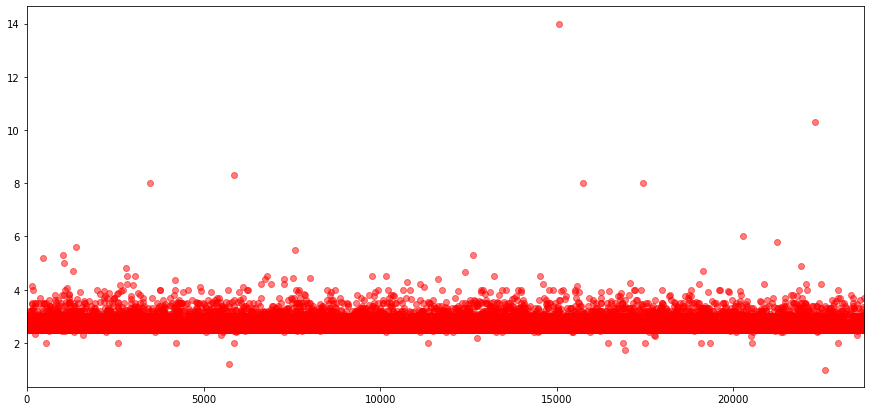

In [15]:
df.ceiling_height.plot(style="ro", figsize=(15,7), alpha=0.5)
plt.show()

Дропнем аномально низкие потолки

In [16]:
df[df.ceiling_height < 2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,...,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,NaN,...,10.00,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


In [17]:
df = df.drop([5712])
df = df.drop([16934])
df = df.drop([22590])

In [18]:
df.reset_index(inplace=True) #Дадим новые индексы

In [19]:
df.drop(labels='index', axis=1, inplace=True)

In [20]:
print("Среднее по высоте потолков:", df.ceiling_height.mean())
print("Медиана по высоте потолков:", df.ceiling_height.median())

Среднее по высоте потолков: 2.729396593338391
Медиана по высоте потолков: 2.65


###### Заполним пропущенные значения столбцов `airports_nearest` , `cityCenters_nearest` , `parks_nearest` , `ponds_nearest`  на максимальное значение по столбцу, предполагая, что данные объекты находятся очень далеко

In [21]:
df['airports_nearest'] = df['airports_nearest'].fillna(df['airports_nearest'].max())
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(df['cityCenters_nearest'].max())
df['parks_nearest'] = df['parks_nearest'].fillna(df['parks_nearest'].max())
df['ponds_nearest'] = df['ponds_nearest'].fillna(df['ponds_nearest'].max())

### Заполним пропущенные значения этажности

In [22]:
print("Пропущенных значений этажности дома:", df.floors_total.isna().sum())

Пропущенных значений этажности дома: 86


#### Создадим для этого сводную таблицу, где индексами будет выступать `расстояние до центра`, а столбцами - `расстояния до аэропорта`

In [23]:
floors_pivot = df.pivot_table(index='cityCenters_nearest', columns='airports_nearest', values='floors_total', aggfunc='first')

In [24]:
floors_pivot.index = floors_pivot.index.values.astype(int)
floors_pivot.columns = floors_pivot.columns.astype(int) # Преобразуем индексы pivot_table в тип int

###### Для этого используем цикл, пробегающий по датафрейму, где пропущены значения `этажности` дома

In [25]:
for index, row in df[df.ceiling_height.isna()].iterrows() :
    
    try:
        cell = floors_pivot.loc[ (row['cityCenters_nearest']) , (row['airports_nearest']) ]
        
        if not(pd.isnull(cell)):                       # Проверяем не равно ли NaN значение ячейки в pivot_table
            df.loc[index, 'floors_total'] = cell       # Заменяем пропущенное значение этажности в нашем df на значение из pivot
    
    except:
        print('Не вышло') # В случае если такого дома не существует

Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло
Не вышло


###### Оставшиеся 14 пропусков этажности заполним медианными значениями, не получилось заменить те значения, где нет подобного сочетания расстояний, т.е. дом не существует. Большую часть значений удалось заменить, значит многие дома встречаются как минимум дважды

In [26]:
df.floors_total.fillna(value=df['floors_total'].median(), inplace=True)

In [27]:
print("Пропусков:", df.floors_total.isna().sum())

Пропусков: 0


#### Проделаем то же самое со значениями `высоты потолков`

In [28]:
ceilings_pivot = df.pivot_table(index='cityCenters_nearest', columns='airports_nearest', values='ceiling_height', aggfunc='first')
ceilings_pivot.index = ceilings_pivot.index.values.astype(int)
ceilings_pivot.columns = ceilings_pivot.columns.astype(int) # Преобразуем индексы pivot_table в тип int

In [29]:
for index, row in df[df.ceiling_height.isna()].iterrows() :
    
    try:
        cell = ceilings_pivot.loc[ (row['cityCenters_nearest']) , (row['airports_nearest']) ]
        
        if not(pd.isnull(cell)):                       # Проверяем не равно ли NaN значение ячейки в pivot_table
            df.loc[index, 'ceiling_height'] = cell       # Заменяем пропущенное значение этажности в нашем df на значение из pivot
    
    except:
        pass # В случае если такого дома не существует

In [30]:
df.ceiling_height.isna().sum()

2907

Таким способом нам удалось устранить более 6000 пропусков абсолютно правильными значениями

#### Теперь, наконец, можно заполнить пропуски высоты потолков медианными значениями в зависимости от этажности дома:

In [31]:
print("Количество пропусков в столбце высоты потолков:", df.ceiling_height.isna().sum())

Количество пропусков в столбце высоты потолков: 2907


In [32]:
floors_ceiling_height = df.pivot_table(index='floors_total', values='ceiling_height', aggfunc='median')
floors_ceiling_height.columns = ['median_ceiling_height']
floors_ceiling_height.head(3)

,median_ceiling_height
floors_total,
1.0,2.8
2.0,2.7
3.0,2.8


In [33]:
floors_ceiling_height['median_ceiling_height'].value_counts()

2.700    10
2.750     7
2.600     3
2.650     3
2.800     3
3.000     3
2.550     2
2.880     1
2.710     1
2.755     1
Name: median_ceiling_height, dtype: int64

In [34]:
def ceiling_height_imputer(row):
    """
    Функция берет на вход значение этажей в доме и заполняет пропущенное значение 
    высоты потолков на медианное, посчитанное в floors_ceiling_height
    """
    floors = row['floors_total']
    if floors in floors_ceiling_height.index.values:
        ceiling_height = floors_ceiling_height.loc[floors, 'median_ceiling_height']
        if pd.isnull(row['ceiling_height']):
            return ceiling_height
    return row['ceiling_height']

In [35]:
df['ceiling_height'] = df.apply(ceiling_height_imputer, axis=1)

In [36]:
print("Количество пропусков в столбце высоты потолков:", df.ceiling_height.isna().sum())

Количество пропусков в столбце высоты потолков: 0


### Заполним оставшиеся пропуски


In [37]:
df.fillna( 
    value =     
                {
                 'living_area' : df['living_area'].median(),   # Заполним пропуски в столбце жилой и кухонной
                 'kitchen_area' : df['kitchen_area'].median(), # площади на медианное значение
                 'is_apartment' : False,                       # Заполним пропуски на False в столбце is_apartment
                 'balcony' : 0,                             
                 'parks_around3000' : 0,
                 'ponds_around3000' : 0,
                 'locality_name' : " ",                        # Заполним пропущенные значения locality_name на пустую строку
                 }, 
          
                  inplace=True )

### Единственными пропущенными значениями остались `количество дней`, которые квартира находилась на продаже

##### Заполнять их будем в соответствии с ценой (из предположения, чем дороже кв. - тем дольше она продается)

Добавим столбец децилей `last_price` в наш df 

In [38]:
df['price_deciles'] = pd.DataFrame(pd.qcut(df['last_price'], q=10))

In [39]:
def fill_na_days_exposition(row):
    days = row['days_exposition']
    price = row['last_price']
    concrete_decile = row['price_deciles']
    if (pd.isnull(days)):
        return df[df['price_deciles'] == concrete_decile]['days_exposition'].median()
        # Заполняем медианой в соответствии с ценовым диапазоном
    return days

In [40]:
df['days_exposition'] = df.apply(fill_na_days_exposition, axis=1)

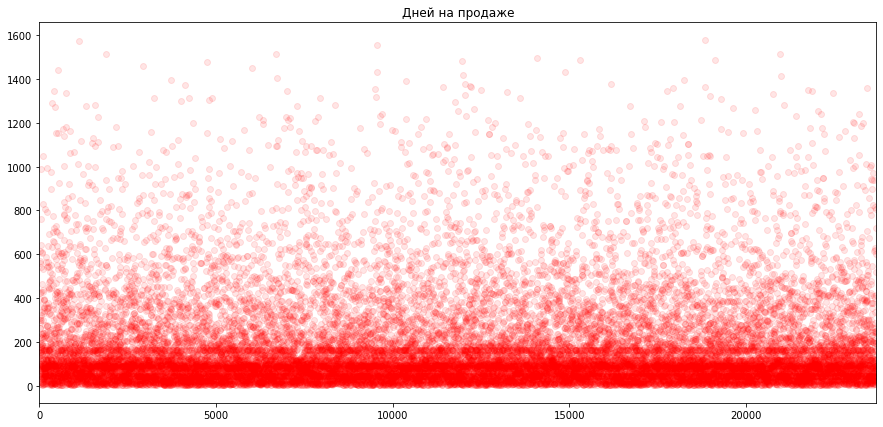

In [41]:
df.days_exposition.plot(style="ro", figsize=(15,7), alpha=0.1, title='Дней на продаже')
plt.show()

######  Отметим большое количество выбросов, хотя основная доля данных лежит в промежутке от ~0 до ~200

In [114]:
df.days_exposition.isna().sum() # Пропусков нет

0

#### Убедимся, что мы успешно избавились от всех пропущенных значений

In [115]:
print("Суммарное кол-во пропусков в датафрейме:" ,df.isna().sum().sum() )

Суммарное кол-во пропусков в датафрейме: 0


### Обработаем столбец с `временем`

In [44]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [45]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_deciles
0,20,13000000.0,108.0,2019-03-07,3,2.700,16.0,51.0,8,False,...,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,161.0,"(10907440.0, 763000000.0]"
1,7,3350000.0,40.4,2018-12-04,1,2.755,11.0,18.6,1,False,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,3190.0,0.0,1344.0,81.0,"(3190000.0, 3650000.0]"
2,10,5196000.0,56.0,2015-08-20,2,2.550,5.0,34.3,4,False,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,"(4650000.0, 5295000.0]"


### Преобразуем типы данных

In [47]:
df['last_price'] = df['last_price'].astype(int)
df['floors_total'] = df.floors_total.astype(int)
df['parks_around3000'] = df['parks_around3000'].astype(int)
df['ponds_around3000'] = df['ponds_around3000'].astype(int)
df['balcony'] = df['balcony'].astype(int)
df['days_exposition'] = df['days_exposition'].astype(int)
df['cityCenters_nearest'] = df['cityCenters_nearest'].astype(int)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23695 entries, 0 to 23694
Data columns (total 23 columns):
total_images            23695 non-null int64
last_price              23695 non-null int64
total_area              23695 non-null float64
first_day_exposition    23695 non-null datetime64[ns]
rooms                   23695 non-null int64
ceiling_height          23695 non-null float64
floors_total            23695 non-null int64
living_area             23695 non-null float64
floor                   23695 non-null int64
is_apartment            23695 non-null bool
studio                  23695 non-null bool
open_plan               23695 non-null bool
kitchen_area            23695 non-null float64
balcony                 23695 non-null int64
locality_name           23695 non-null object
airports_nearest        23695 non-null float64
cityCenters_nearest     23695 non-null int64
parks_around3000        23695 non-null int64
parks_nearest           23695 non-null float64
ponds_around3000 

### Рассмотрим столбец `rooms` , так как в нем встречаются квартиры с 0 комнат

In [49]:
df[df.rooms == 0]['total_area'].value_counts().sort_index().tail(10)

38.30     1
42.10     1
42.63     1
43.30     1
44.20     1
58.40     1
71.00     1
73.60     1
98.40     1
371.00    1
Name: total_area, dtype: int64

Скорее всего это пропуски при заполнении данных, заменим количество комнат для квартир площадью менее 45 кв.м. на 1, для тех у которых меньше 100 кв.м. на 2, для остальных - на 5 

In [50]:
def rooms_imputer(row):
    if row['rooms'] == 0:
        if row['total_area'] < 45:
            return 1
        if row['total_area'] < 100:
            return 2
        return 5
    return row['rooms']

In [51]:
df['rooms'] = df.apply(rooms_imputer, axis=1)

### Проверим количество дупликатов:

In [53]:
print("Количество дупликатов:", df.duplicated().sum())

Количество дупликатов: 0


# Вывод

>На данном этапе мы произвели множественные замены пропущенных значений. Для многих квартир отсутствовали значения `этажности` или `высоты потолков` - многие из них нам удалось восстановить из имеющихся данных, поскольку дома в датасете повторяются. 
Для пропущенных значений расстояний была применена стратегия заполнения по максимальному значению в столбце.
Произвели частичную очистку данных от выбросов.
Количественные параметры: `living_area` , `kitchen_area` были заменены на медианные. 
Также преобразованы типы данных: из строковых в формат даты, из чисел с плавающей точкой в целочисленный. 
Длительность продажи была заполнена медианными значениями в зависимости от стоимости квартиры.
Нулевое количество комнат было заменено в соответствии с площадью квартиры. Дупликатов в данных не обнаружилось.

### Шаг 3. Посчитайте и добавьте в таблицу

###### Добавим цену за кв. метр. в таблицу

In [54]:
df['price_for_square_meter'] = df['last_price'] / df['total_area']

###### Добавим столбцы с днем недели, месяцем и годом

In [55]:
df['weekday'] = df['first_day_exposition'].dt.weekday

In [56]:
df['month'] = df['first_day_exposition'].dt.month

In [57]:
df['year'] = df['first_day_exposition'].dt.year

###### Столбец с этажом: первый, последний, другой

In [58]:
def flat_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [59]:
df['floor_category'] = df.apply(flat_floor, axis=1)

In [60]:
df.floor_category.value_counts() 

другой       17844
последний     2935
первый        2916
Name: floor_category, dtype: int64

первых и последних этажей примерно одинаковое количество

###### Добавим отношение жилой площади к общей

In [61]:
df['living_to_total'] = df.living_area / df.total_area

###### Добавим отношение площади кухни к общей

In [62]:
df['kitchen_to_total'] = df.kitchen_area / df.total_area

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Построим гистограммы распределения  `Общей площади`  ,  `Цены`  ,  `Комнат`  ,  `Высоты потолков`

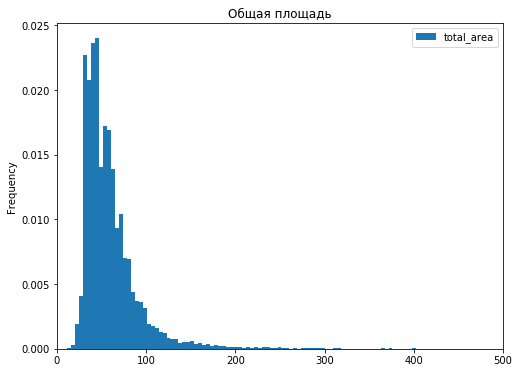

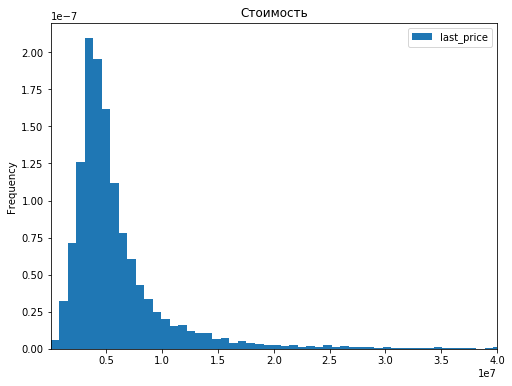

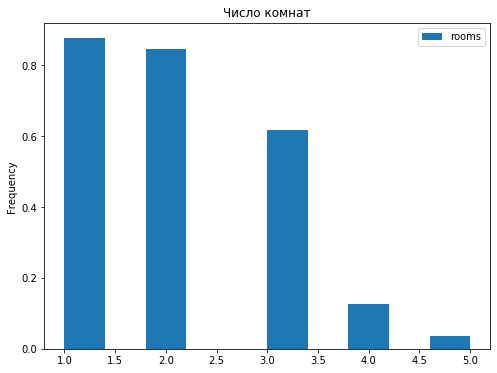

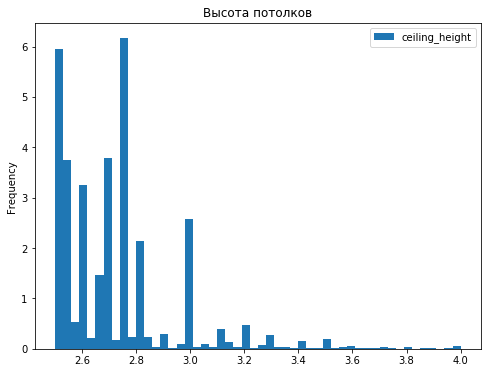

In [63]:
df.plot(y='total_area', kind='hist', density=True, bins=200, xlim=(0,500), figsize=(8,6), title='Общая площадь')
df.plot(y='last_price', kind='hist', density=True, bins=1000, xlim=(12190,40000000.0), figsize=(8,6), title='Стоимость')
df.plot(y='rooms', kind='hist', density=True, bins=10, range=(1, 5), figsize=(8,6), title='Число комнат')
df.plot(y='ceiling_height', kind='hist', bins=50, range=(2.5, 4), density=True, figsize=(8,6), title='Высота потолков')
plt.show()

In [118]:
print("Медианное значение площади:", df.total_area.median() )

Медианное значение площади: 52.0


In [117]:
print("Медианное значение цены:", df.last_price.median() )

Медианное значение цены: 4650000.0


In [116]:
print("Медианное значение высоты потолков:", df.ceiling_height.median() )

Медианное значение высоты потолков: 2.7


### Вывод

>Медианное значение площади - 50 кв.м., распределение имеет вид Пуассоновского с пиком около 40 кв.м. Медианная стоимость квартиры составляет 4.6 млн. Наибольшее количество квартир однокомнатные, хотя двухкомнатных всего лишь немногим меньше. Высота потолков составляет 2.7 метра.

#### Рассмотрим распределение времени продаж

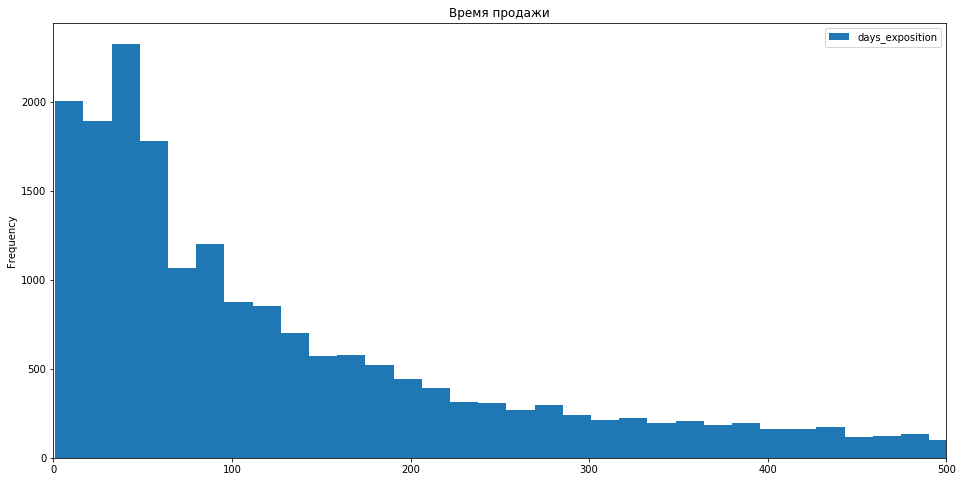

In [64]:
data.plot(y='days_exposition', kind='hist', bins=100, figsize=(16,8), xlim=(0,500), title='Время продажи')
plt.show()

In [65]:
data.days_exposition.describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

#### Медианное значение времени продажи квартиры составляет 95 дней, среднее - 180 , что говорит о наличии сильных выбросов

In [120]:
data.days_exposition.value_counts().sort_index().tail(777) # 777 и больше выбросов

365.0     17
366.0     14
367.0     13
368.0      8
369.0     12
          ..
1512.0     2
1513.0     1
1553.0     1
1572.0     1
1580.0     1
Name: days_exposition, Length: 777, dtype: int64

#### Будем считать продажу быстрой, если она уложилась в неделю, и медленной, если она длилась более года

In [122]:
good_exposition_data = data.query('7<days_exposition<366')['days_exposition'] # избавляемся от выбросов и аномальных 
                                                                              # по скорости продаж
good_exposition_data = good_exposition_data.astype(int)

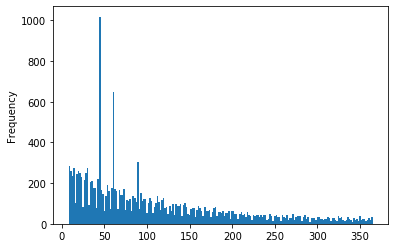

In [123]:
good_exposition_data.plot(kind='hist', bins=200)
plt.show()

Видны явные аномалии

In [69]:
good_exposition_data.value_counts().head()

45    880
60    538
30    208
90    204
14    148
Name: days_exposition, dtype: int64

#### Значения 45, 60, 30, 90 - самые популярные и явно отличаются от других в большую сторону, вероятно данные искусственные и эти значения использовались для заполнения пропусков

Попробуем убрать эти значения из рассмотрения и проверить, как будет выглядеть распределение:

In [70]:
good_exposition_data = good_exposition_data.astype(int)

In [71]:
good_exposition_data = good_exposition_data.where(good_exposition_data != 45)
good_exposition_data = good_exposition_data.where(good_exposition_data != 60)
good_exposition_data = good_exposition_data.where(good_exposition_data != 30)
good_exposition_data = good_exposition_data.where(good_exposition_data != 90)

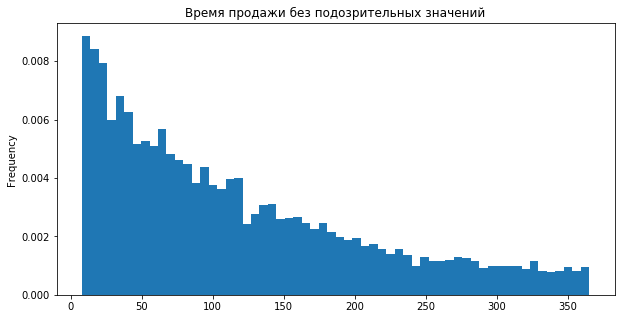

In [72]:
good_exposition_data.plot(kind='hist', bins=60, density=True, figsize=(10,5), title='Время продажи без подозрительных значений')
plt.show()

In [73]:
good_exposition_data.median()

92.0

Гистограмма похожа на распределение Пуассона, мединное значение времени продажи - порядка 90-95 дней

### Посмотрим, как стоимость `Квартиры` зависит от `площади` ,  `числа комнат`  ,  `удалённости от центра`.

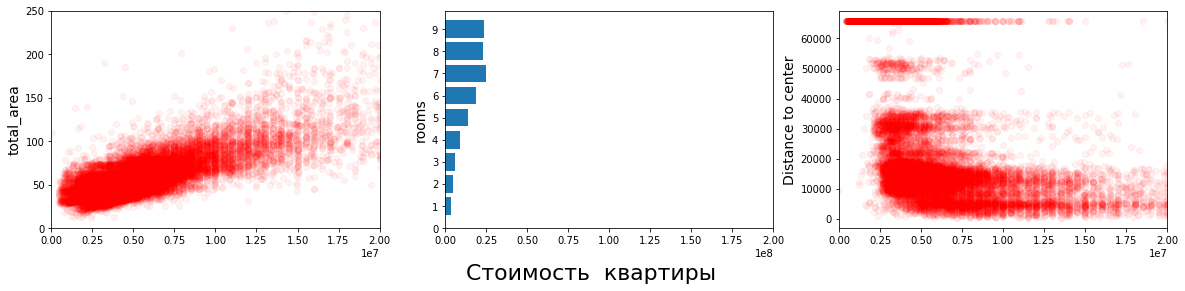

In [125]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
fig.suptitle('Стоимость  квартиры', y=0.001, fontsize=22)

ax1.scatter(df['last_price'], df['total_area'], c='r', alpha=0.05)
ax1.set_xlim([0,20000000])
ax1.set_ylim([0,250])
ax1.set_ylabel('total_area', fontsize=14)

df_normal_amount_of_rooms = df.query('rooms < 10')
rooms_price = df_normal_amount_of_rooms[['rooms', 'last_price']].groupby(['rooms']).median()
ax2.barh( rooms_price.index, rooms_price['last_price'] )
ax2.set_xlim([0,200000000])
ax2.set_ylabel('rooms', fontsize=14)
y_pos = np.arange(0,10)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([str(i) for i in range(0,10)])

ax3.scatter(df['last_price'], df['cityCenters_nearest'], c='r', alpha=0.05)
ax3.set_xlim([0,20000000])
ax3.set_ylabel('Distance to center', fontsize=14)


plt.show()

In [75]:
df[['last_price','total_area']].corr()

,last_price,total_area
last_price,1.000000,0.653726
total_area,0.653726,1.000000


In [76]:
df[['last_price','cityCenters_nearest']].corr()

,last_price,cityCenters_nearest
last_price,1.000000,-0.228314
cityCenters_nearest,-0.228314,1.000000


In [77]:
df[['last_price','rooms']].corr()

,last_price,rooms
last_price,1.000000,0.366223
rooms,0.366223,1.000000


#### На графике зависимости стоимости квартиры от общей площади явно видна положительная корреляция.
#### На столбчатой диаграмме также заметна увеличивающаяся стоимость квартиры с увеличением числа комнат.
#### На графике зависимости стоимости квартиры от расстояния до центра города также видна зависимость, предположительно - гиперболическая. Чем дальше квартира - тем дешевле она стоит

## Рассмотрим как зависит стоимость квартиры от этажа

In [78]:
floor_price = df[['floor_category', 'last_price']].groupby(['floor_category']).median().sort_values('last_price')

In [79]:
floor_price

,last_price
floor_category,
первый,3900000
последний,4600000
другой,4799000


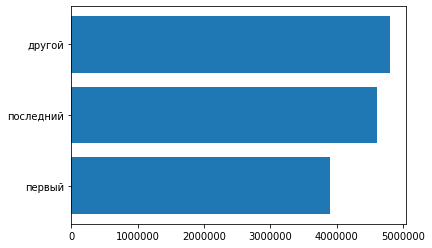

In [80]:
plt.barh( floor_price.index, floor_price['last_price'] )
plt.show()

#### Квартиры на первом этаже, как правило, дешевле других. Квартиры на последнем и других этажах стоят приблизительно одинаково.

## Рассмотрим как зависит стоимость квартиры от даты размещения: дня недели, месяца и года.

##### Год

In [81]:
year_price = df[['year', 'last_price']].groupby(['year']).median().sort_index()

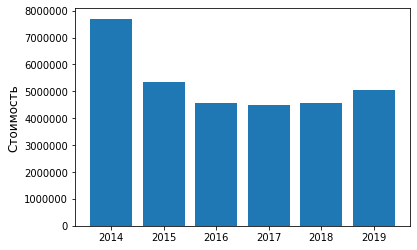

In [82]:
plt.bar( year_price.index, year_price['last_price'] )
plt.ylabel("Стоимость", fontsize=12)
plt.show()

#### С 2014 года стоимость квартир сильно упала, однако с 2019 тренд меняется и возможен последующий рост стоимости

##### Месяц

In [83]:
month_price = df[['month', 'last_price']].groupby(['month']).median().sort_index()

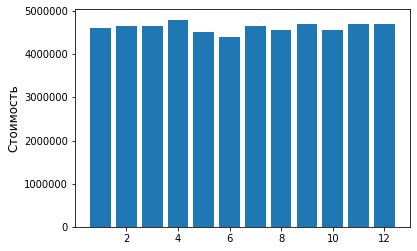

In [84]:
plt.bar( month_price.index, month_price['last_price'] )
plt.ylabel("Стоимость", fontsize=12)
plt.show()

##### От времени года стоимость практически не зависит

##### День

In [85]:
day_price = df[['weekday', 'last_price']].groupby(['weekday']).median().sort_index()

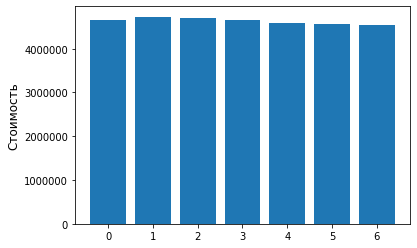

In [86]:
plt.bar( day_price.index, day_price['last_price'] )
plt.ylabel("Стоимость", fontsize=12)
plt.show()

##### От дня размещения объявления стоимость также практически не меняется

In [87]:
top_locals = df.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10).index.values.tolist()

In [88]:
df_filtered = df.query('locality_name in @top_locals')

In [89]:
df_filtered.groupby('locality_name')['price_for_square_meter'].mean().sort_values(ascending=False)

locality_name
Санкт-Петербург      114819.294843
Пушкин               103125.819291
деревня Кудрово       92473.547576
посёлок Парголово     90175.913458
посёлок Мурино        85752.189195
посёлок Шушары        78677.364217
Колпино               75424.579098
Гатчина               68746.146763
Всеволожск            68654.473986
Выборг                58141.909153
Name: price_for_square_meter, dtype: float64

#### Самые дорогие квартиры располагаются, ожидаемо, в Санкт-Петербурге (115 тыс.), затем идет Пушкин. Низкая стоимость квартир в Выборге - в два раза дешевле, чем в Санкт-Петербурге. Во Всеволожске и Гатчине примерно одинаковые цены за кв.м., порядка 68 тыс.

## Стоимость квартир в центре

In [90]:
df['kilometres_to_cityCenters'] =( df['cityCenters_nearest']/1000 ).astype(int)

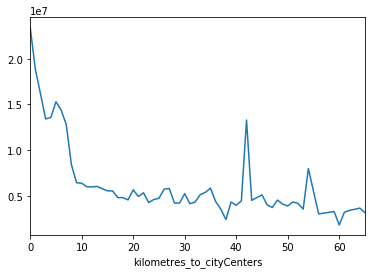

In [91]:
kilometres_to_cityCenters = df.groupby('kilometres_to_cityCenters')['last_price'].mean().plot()

### На графике видно, что цена сильно меняется на 8-9 километрах, следовательно это и есть граница центра города

## Проанализируем квартиры в центре

In [92]:
df_flats_in_center = df.query('kilometres_to_cityCenters <=8')

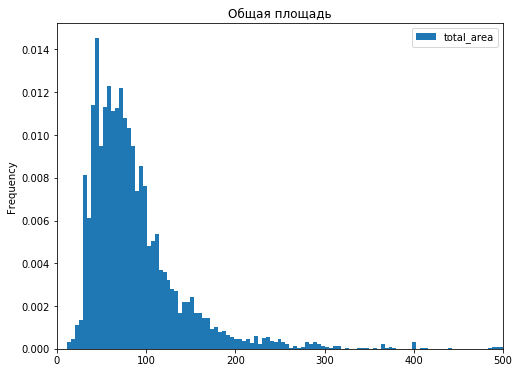

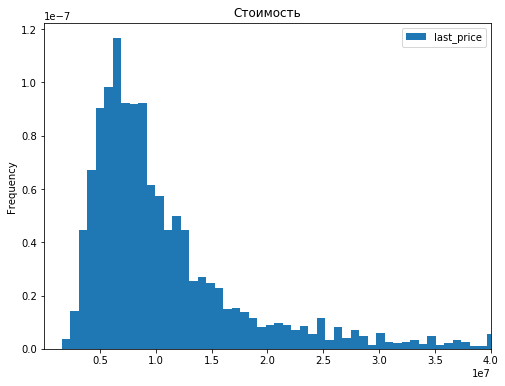

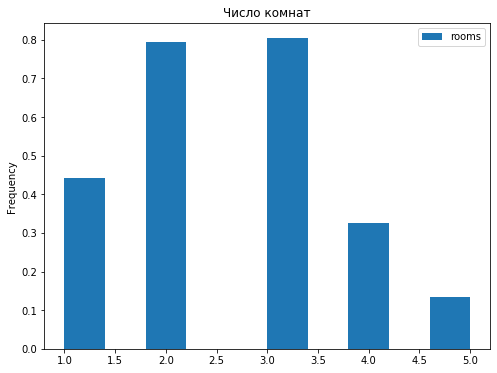

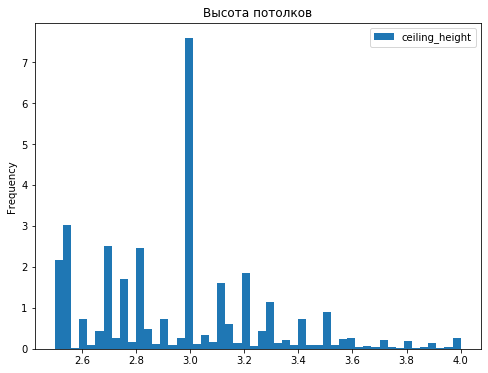

In [93]:
df_flats_in_center.plot(y='total_area', kind='hist', density=True, bins=200, xlim=(0,500), figsize=(8,6), title='Общая площадь')
df_flats_in_center.plot(y='last_price', kind='hist', density=True, bins=1000, xlim=(12190,40000000.0), figsize=(8,6), title='Стоимость')
df_flats_in_center.plot(y='rooms', kind='hist', density=True, bins=10, range=(1, 5), figsize=(8,6), title='Число комнат')
df_flats_in_center.plot(y='ceiling_height', kind='hist', bins=50, range=(2.5, 4), density=True, figsize=(8,6), title='Высота потолков')
plt.show()

In [128]:
print("Медианное значение площади", df_flats_in_center['total_area'].median() )

Медианное значение площади 75.0


In [127]:
print("Медианное значение цены", df_flats_in_center['last_price'].median() )

Медианное значение цены 8700000.0


In [129]:
print("Медианное значение высоты потолков", df_flats_in_center.ceiling_height.median() )

Медианное значение высоты потолков 3.0


### Квартиры в центре города могут "похвастать" большей площадью - 75 кв.м. Такие квартиры также в среднем более дорогие, медианная стоимость составляет почти 9 млн. В то время, как для всех квартир эта стоимость равняется 4,5 миллионам. Квартиры в центре также чаще двух- или трехкомнатные, тогда как в общей массе больше "однушек". У данных квартир также выше потолки, в среднем - 3 метра.

## Посмотрим какие факторы влияют на стоимость квартиры  в центре (`число комнат`, `этаж`, `удалённость от центра`, `дата размещения объявления`) и сравним с общим выводом

### Число комнат

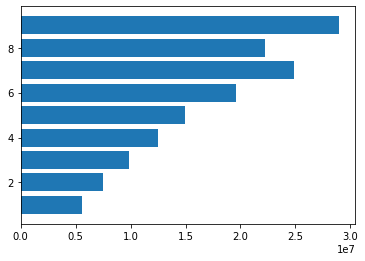

In [131]:
df_flats_in_center_normalRooms = df_flats_in_center.query('rooms < 10')
rooms_price_center = df_flats_in_center_normalRooms[['rooms', 'last_price']].groupby(['rooms']).median()
plt.barh( rooms_price_center.index, rooms_price_center['last_price'] )
plt.show()

#### Стоимость квартиры также увеличивается в зависимости от количества комнат, как и во всем датасете

### Этаж

In [132]:
floor_price_center = ( df_flats_in_center[['floor_category', 'last_price']].groupby('floor_category').median()
                      .sort_values('last_price') )

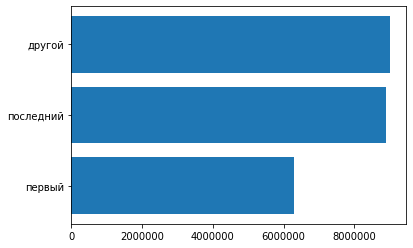

In [133]:
plt.barh( floor_price_center.index, floor_price_center['last_price'] )
plt.show()

#### На первом этаже в центре города квартиры также дешевле.

### Удаленность

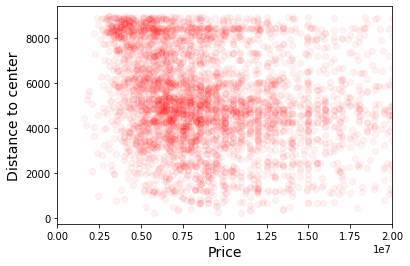

In [100]:
plt.scatter(df_flats_in_center['last_price'], df_flats_in_center['cityCenters_nearest'], c='r', alpha=0.05)
plt.xlim(0,20000000)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Distance to center', fontsize=14)
plt.show()

In [101]:
df_flats_in_center[['last_price', 'cityCenters_nearest']].corr()

,last_price,cityCenters_nearest
last_price,1.00000,-0.10059
cityCenters_nearest,-0.10059,1.00000


#### А вот зависимости от удаленности нет, квартиры могут стоить в центре по разному.

### Посмотрим зависимость от даты

### Год

In [102]:
year_price_center = df_flats_in_center[['year', 'last_price']].groupby(['year']).median().sort_index()

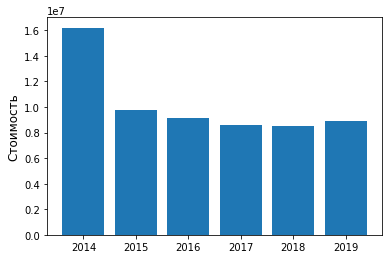

In [103]:
plt.bar( year_price_center.index, year_price_center['last_price'] )
plt.ylabel("Стоимость", fontsize=12)
plt.show()

#### Диаграмма точно такая же, как и для всей выборки, с 2014 стоимость упала, а в 2019 начинает немного расти

### Месяц

In [104]:
month_price_center = df_flats_in_center[['month', 'last_price']].groupby(['month']).median().sort_index()

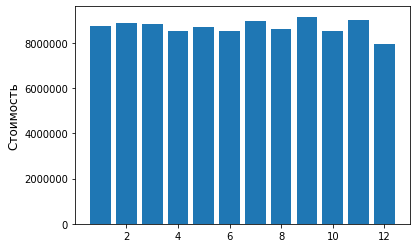

In [105]:
plt.bar( month_price_center.index, month_price_center['last_price'] )
plt.ylabel("Стоимость", fontsize=12)
plt.show()

#### Зависимости от времени года все также не наблюдается.

### Шаг 5. Общий вывод

1. На первом шаге при знакомстве с датасетом были обнаружены множественные пропуски, а также много аномалий, от которых мы в последствии успешно избавились. 
2. На втором этапе для пропущенных значений этажности и высоты потолков домов были восстановлены значения по доступным данным из датасета. Изменены типы данных, обработаны выбросы и аномальные значения.
3. На третьем шаге были посчитаны и добавлены в таблицу:
    1. цена квадратного метра;
    2. день недели, месяц и год публикации объявления;
    3. этаж квартиры; варианты — первый, последний, другой;
    4. соотношение жилой и общей площади, а также отношение площади кухни к общей.
4. На четвертом этапе был произведен исследовательский анализ данных и выявлено, что:
    1. В среднем квартира продается около трех месяцев
    2. Стоимость квартиры зависит пропорционально  от площади, количества комнат и обратно пропорционально расстоянию до центра
    3. На первом этаже квартиры стоят дешевле
    4. Стоимость квартир с 2014 по 2019 снизилась на 2,5 млн. руб.
    5. Зависимости стоимости продажи от времени года или дня недели обнаружено не было
    6. Самые дорогие квартиры находятся в Санкт-Петербурге и Пушкине, а самые дешевые в Выборге
    7. Граница центра - 9 километров
    8. Квартиры в центре сильно отличаются в цене, примерно в два раза дороже. Площадь квартир больше в среднем на 30 кв.м. Чаще встречаются двух- и трехкомнатные квартиры, нежели однокомнатные. Более высокие потолки - 3 метра, для остальных квартир из датасета - 2,7. 
    9. Стоимость квартир в центре также зависит от количества комнат, от этажа (на первом - дешевле), а от удаленности цена квартиры не зависит, в отличие от квартир из всей выборки.
    10. Стоимость квартир в центре Санкт-Петербурга также упала с 2014 года.
    11. Зависимости от времени года продажи квартиры не обнаружено.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод info())
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  посчитано и добавлено в таблицу: цена квадратного метра
- [ ]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [ ]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [ ]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [ ]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [ ]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [ ]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [ ]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [ ]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [ ]  в каждом этапе есть выводы
- [ ]  есть общий вывод